# LRP

Implementation of Layer-wise Relevance Propagation (LRP) in PyTorch.

## Setup

In [1]:
import myutils
img = myutils.load_normalized_img('castle.jpg')
X = myutils.img_to_tensor(img)

import torchvision
model = torchvision.models.vgg16(pretrained=True)
model.eval()

import utils
import torch

## Zennit-inspired arch

### LRP-0/-gamma/-epsilon

In [4]:
from custom_zennit.core import mod_params, stabilize
import copy

class LrpRule(torch.nn.Module):
  def __init__(self, layer, param_modifiers) -> None:
      super().__init__()
      self.layer = layer

      for layer_name, param_mod in param_modifiers:
        # Create a new layer that applies the parameter modifier
        setattr(self, layer_name, copy.deepcopy(layer))
        copy_layer = getattr(self, layer_name)
        mod_params(copy_layer, param_mod)
  
  def forward(self, z, output):
    # output is result of original forward function
    return z * (output / stabilize(z)).detach()


class LrpGenericRule(LrpRule):
  def __init__(self, layer, epsilon, gamma) -> None:
    param_modifiers = [
      ('copy_layer', lambda _, param: param + gamma * param.clamp(min=0))
    ]
    self.epsilon = epsilon
    # self.gamma = gamma
    super().__init__(layer, param_modifiers)

  def forward(self, X):
    output = self.layer.forward(X)
    z = self.epsilon + self.copy_layer.forward(X)

    return super().forward(z, output)

class LrpZeroRule(LrpGenericRule):
  def __init__(self, layer) -> None:
    super().__init__(layer, epsilon=0, gamma=0)

class LrpEpsilonRule(LrpGenericRule):
  def __init__(self, layer, epsilon) -> None:
    super().__init__(layer, epsilon, gamma=0)

class LrpGammaRule(LrpGenericRule):
  def __init__(self, layer, gamma) -> None:
    super().__init__(layer, 0, gamma)

### ZBox-Rule

In [5]:
import torch
from myutils import ILSVRC2012_BatchNormalize
batch_size = 1
shape = (batch_size, 3, 224, 224)
norm_fn = ILSVRC2012_BatchNormalize()
low = norm_fn(torch.zeros(*shape))
high = norm_fn(torch.ones(*shape))


class LrpZBoxRule(LrpRule):
  def __init__(self, layer, low, high):
    param_modifiers = [
      ('low_layer', lambda _, param: param.clamp(min=0)),
      ('high_layer', lambda _, param: param.clamp(max=0))
    ]
    super().__init__(layer, param_modifiers)
    self.low = low
    self.high = high
    self.low.requires_grad = True
    self.high.requires_grad = True

  def forward(self, X):
    output = self.layer.forward(X)
    
    z_low = self.low_layer.forward(self.low)
    z_high = self.high_layer.forward(self.high)
    z = output - z_low - z_high

    return super().forward(z, output)

### LRP Attribution

In [6]:
class LRP():
  def __init__(self, model) -> None:
      self.model = model
      self.model.eval()


  # def toconv()


  @staticmethod
  def convert_single_layer(i, layer):
    # if isinstance(layer, torch.nn.Linear):
    #   layer = toconv(layer)


    if not isinstance(layer, torch.nn.Conv2d):
      return layer

    if i == 0:
      # First layer is the pixel layer
      # return layer
      print(f'Layer {i}: LRP ZBox')
      return LrpZBoxRule(layer, low=low, high=high)

    # Case: bottom layers, apply LRP-Gamma with gamma = 0.25
    if i <= 16:
      print(f'Layer {i}: LRP-Gamma with gamma = 0.25')
      return LrpGammaRule(layer, gamma=0.25)

    # Case: middle layers, apply LRP-Epsilon with epsilon = 0.25. Alt. 1e-6
    if 17 <= i <= 30:
      print(f'Layer {i}: LRP-Epsilon with epsilon = 0.25')
      return LrpEpsilonRule(layer, epsilon=0.25)

    # Case: top layers, apply LRP-0
    if i >= 31:
      print(f'Layer {i}: LRP-Zero')
      return LrpZeroRule(layer)

  def convert_layers(self):
    for i, layer in enumerate(self.model.features):
      self.model.features[i] = LRP.convert_single_layer(i, layer)

    self.model.avgpool = LrpZeroRule(self.model.avgpool)

    for i, layer in enumerate(self.model.classifier):
      self.model.classifier[i] = self.convert_single_layer(31+i, layer)

  def relevance(self, X):
    # Apply Gradient x Input
    # Prepare to compute input gradient

    # Reset gradient
    self.model.zero_grad()
    X.requires_grad = True

    # Compute explanation
    # Stores value of gradient in X.grad
    # [0].max() retrieves the maximum activation/relevance in the first layer
    # = 483 for castle
    self.model.forward(X)[0].max().backward()

    # Retrieve gradients from first layer
    first_layer = self.model.features[0]
    l = first_layer.low
    h = first_layer.high
    
    # Calculate gradients
    c1, c2, c3 = X.grad, l.grad, h.grad

    # Calculate relevance
    self.R = X*c1 + l*c2 + h*c3
    return self.R

  def visualize(self):
    utils.heatmap(self.R[0].sum(dim=0).detach().numpy(), 4,4)

Layer 0: LRP ZBox
Layer 2: LRP-Gamma with gamma = 0.25
Layer 5: LRP-Gamma with gamma = 0.25
Layer 7: LRP-Gamma with gamma = 0.25
Layer 10: LRP-Gamma with gamma = 0.25
Layer 12: LRP-Gamma with gamma = 0.25
Layer 14: LRP-Gamma with gamma = 0.25
Layer 17: LRP-Epsilon with epsilon = 0.25
Layer 19: LRP-Epsilon with epsilon = 0.25
Layer 21: LRP-Epsilon with epsilon = 0.25
Layer 24: LRP-Epsilon with epsilon = 0.25
Layer 26: LRP-Epsilon with epsilon = 0.25
Layer 28: LRP-Epsilon with epsilon = 0.25


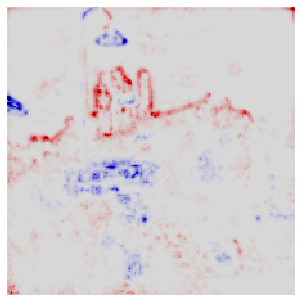

In [7]:
lrp = LRP(model)
lrp.convert_layers()
lrp.relevance(X)
lrp.visualize()

In [8]:
lrp.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

# ToDo:


## Today

- Extend LRP to linear layers
- Refactor code in notebook to files (slim down code in notebook for readability)

---

- Apply different rules by layer type and index
Source: https://github.com/adrhill/ExplainabilityMethods.jl/blob/0a9ca79d75525f99eb59a5d54bc7b0e7486ac614/src/lrp_rules.jl#L84-L88


## Nice-to-haves
- Init packaging environment for lrp repo
- Read icip-2018-interpretable-dl.pdf
- Use torchvision.transforms.Compose
- Integrate DataLoader into notebook
- Add python types to notebook

## Automation

- Automate layer mapping using model.children or model.modules
- Automate modifying the parameters of the model (named_parameters(), see zennit)
- Looping through layers of model (children, modules)

--- 

## Hard

- Canonize models

